# Perkenalan

Muhammad Bintang Ramadhan  
Data Science Batch 08  
live code 1 sesi 2

# Import Pustaka

In [2]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modelling
from sklearn.linear_model import LogisticRegression

#Evaluasi Model
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# Import Data

In [3]:
filecsv = 'https://raw.githubusercontent.com/fahmimnalfrzki/Dataset/main/GalaxyMorphology.csv'
df = pd.read_csv(filecsv,usecols=['C', 'A', 'S', 'G2', 'H', 'CNN2classes1stClass'])
df.head()

,C,A,S,G2,H,CNN2classes1stClass
0,0.357051,0.932151,0.850992,1.588183,0.697214,1
1,0.313292,0.610999,0.723122,1.533653,0.719412,1
2,0.408286,0.881524,0.813231,1.743747,0.750872,1
3,-9999.999999,0.838779,0.816965,1.672529,0.771995,1
4,0.446453,0.839216,0.801140,1.107665,0.610453,1


# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   C                    20000 non-null  float64
 1   A                    20000 non-null  float64
 2   S                    20000 non-null  float64
 3   G2                   20000 non-null  float64
 4   H                    20000 non-null  float64
 5   CNN2classes1stClass  20000 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 937.6 KB


tidak ada missing value

# Data Preprocessing

In [5]:
#Mengambil sepuluh data dari dataset untuk dijadikan data inference
inf = df.sample(5, random_state=33)
inf

,C,A,S,G2,H,CNN2classes1stClass
8537,0.272718,0.748046,0.868688,1.726417,0.799235,1
2077,0.234426,0.884878,0.915706,1.899250,0.821838,1
6433,0.271021,0.805195,0.924032,1.699239,0.829837,1
9274,0.430863,0.884174,0.871320,1.321015,0.648827,1
5940,0.365101,0.769021,0.758763,1.743213,0.786163,1


In [6]:
# Menghapus data Inference dari dalam dataset
df_train_test = df.drop(inf.index)
df_train_test.tail()

,C,A,S,G2,H,CNN2classes1stClass
19995,0.358020,0.602471,0.832848,1.611594,0.735315,1
19996,0.470026,0.842624,0.868289,1.313089,0.649996,1
19997,0.323334,0.830340,0.950820,1.406042,0.671217,1
19998,0.393574,0.632766,0.825990,1.659363,0.379448,1
19999,0.346322,0.878231,0.882251,1.616493,0.738060,1


In [7]:
# Reset Index untuk Data_train_test dan data for inference
df_train_test.reset_index(drop=True, inplace=True)
inf.reset_index(drop=True, inplace=True)

## Feature Selection

Text(0.5, 1.0, 'Heatmap Korelasi')

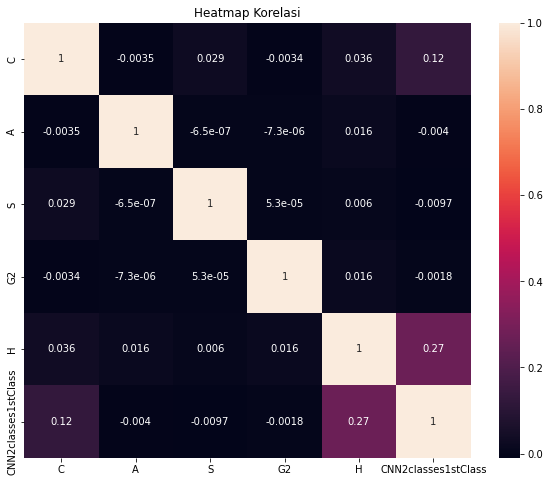

In [8]:
plt.figure(figsize=(10,8)) #Ukuran Plot
sns.heatmap(df_train_test.corr(), annot=True) #Menampilkan korelasi dari df_train_test, yang saya fokuskan korelasi terhadap fitur 'Price'
plt.title('Heatmap Korelasi') #Title plot

H Memiliki High Korelasi, karna fitur lain saya tidak tau sebagai apa makan walaupun korelasi kecil maka akan saya jadikan sebagai fitur, artinya tidak ada yang di drop

## Train Test Split

In [9]:
# Splitting Dataset menggunakan sklearn train_test_split
# Membagi untuk data train 80% dan test 20%
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_train_test, test_size=0.2, random_state=8)

print(train.shape)
print(test.shape)

(15996, 6)
(3999, 6)


## Handling Outliers

In [10]:
#function histplot dan boxplot untuk melihat distribusi data
def identify_plots(df, variable):
    plt.figure(figsize=(16, 4))

    # Plot 1 Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Plot 2 Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

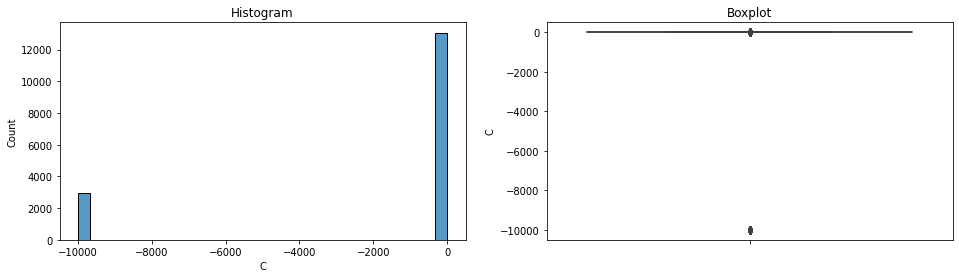

Nilai Skew :  -1.6372531707178837



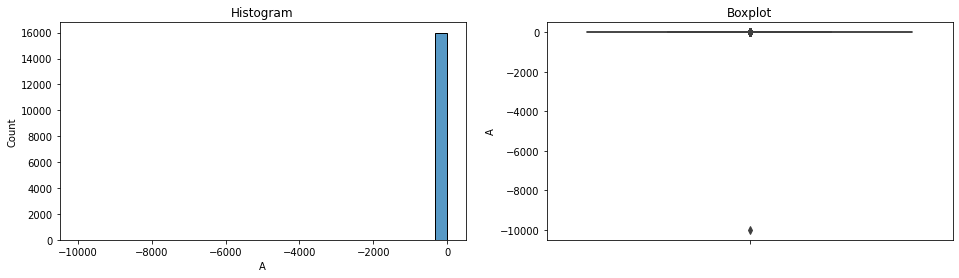

Nilai Skew :  -126.47482654107661



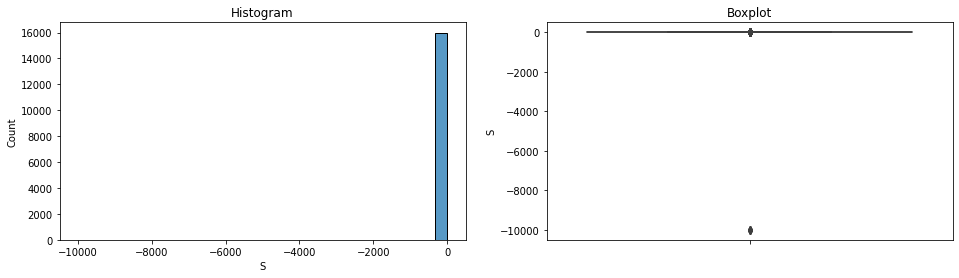

Nilai Skew :  -44.686362019635894



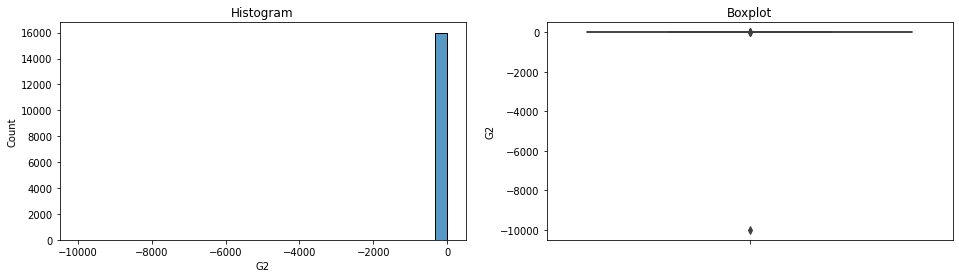

Nilai Skew :  -126.46945642313811



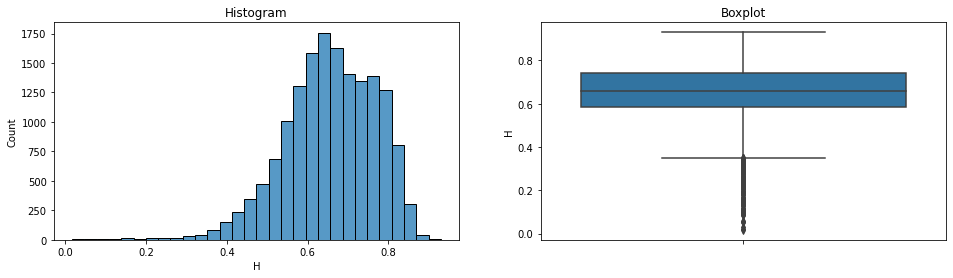

Nilai Skew :  -0.6832318920409565



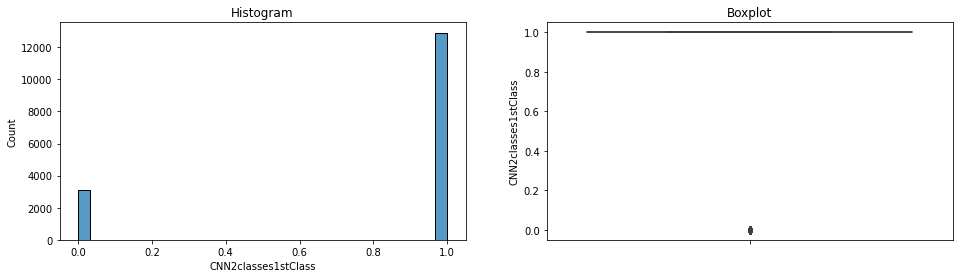

Nilai Skew :  -1.553518208764979



In [11]:
for var in train.select_dtypes(np.number): #Looping semua data dtrain Numerik
    identify_plots(train, var)
    print('Nilai Skew : ', train[var].skew()) #Nilai skewness dari tiap data numerik 
    print()

- Semua Fitur Skewness (-)

## Outliers Detection

In [12]:
#Membuat function untuk menemukan batas atas dan batas bawah menggunakan IQR
def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25) #IQR = Q3 - Q1

    lower_boundary_skew = df[variable].quantile(0.25) - (IQR * distance) #batas bawah
    upper_boundary_skew = df[variable].quantile(0.75) + (IQR * distance) #batas atas

    return upper_boundary_skew, lower_boundary_skew

Melihat Jumlah Outliers

In [13]:
df.head(2)

,C,A,S,G2,H,CNN2classes1stClass
0,0.357051,0.932151,0.850992,1.588183,0.697214,1
1,0.313292,0.610999,0.723122,1.533653,0.719412,1


C

In [14]:
# Melihat batas atas dan batas bawah variable C
C_upper_boundary_skew, C_lower_boundary_skew = find_skewed_boundaries(train, 'C', 1.5)
C_upper_boundary_skew, C_lower_boundary_skew

(0.6527344978972499, 0.0775380873772501)

In [15]:
# Melihat jumlah dan percent data outliers variable C
print('Jumlah data C dibawah 0.07   : {}'.format(len(train[train['C'] < C_lower_boundary_skew])))
print('% Jumlah data C dibawah 0.07 : {}'.format(len(train[train['C'] < C_lower_boundary_skew])/len(train) * 100))

Jumlah data C dibawah 0.07   : 2932
% Jumlah data C dibawah 0.07 : 18.3295823955989


terdapat ouliers sebanyak 2932 atau 18%

A

In [16]:
# Melihat batas atas dan batas bawah variable A
A_upper_boundary_skew, A_lower_boundary_skew = find_skewed_boundaries(train, 'A', 1.5)
A_upper_boundary_skew, A_lower_boundary_skew

(1.089408352971625, 0.5980433970686252)

In [17]:
# Melihat jumlah dan percent data outliers variable A
print('Jumlah data A dibawah 0.07   : {}'.format(len(train[train['A'] < A_lower_boundary_skew])))
print('% Jumlah data A dibawah 0.07 : {}'.format(len(train[train['A'] < A_lower_boundary_skew])/len(train) * 100))

Jumlah data A dibawah 0.07   : 914
% Jumlah data A dibawah 0.07 : 5.71392848212053


Terdapat ouliers sebanyak 914 atau 5%

S

In [18]:
# Melihat batas atas dan batas bawah variable S
S_upper_boundary_skew, S_lower_boundary_skew = find_skewed_boundaries(train, 'S', 1.5)
S_upper_boundary_skew, S_lower_boundary_skew

(1.08838487416475, 0.5577307417987499)

In [19]:
# Melihat jumlah dan percent data outliers variable S
print('Jumlah data S dibawah 0.5   : {}'.format(len(train[train['S'] < S_lower_boundary_skew])))
print('% Jumlah data S dibawah 0.5 : {}'.format(len(train[train['S'] < S_lower_boundary_skew])/len(train) * 100))

Jumlah data S dibawah 0.5   : 1732
% Jumlah data S dibawah 0.5 : 10.827706926731683


Terdapat 1732 Data outliers atau 10%

G2

In [20]:
# Melihat batas atas dan batas bawah variable G2
G2_upper_boundary_skew, G2_lower_boundary_skew = find_skewed_boundaries(train, 'G2', 1.5)
G2_upper_boundary_skew, G2_lower_boundary_skew

(2.550853051242, 0.036711789669999995)

In [21]:
# Melihat jumlah dan percent data outliers variable G2
print('Jumlah data G2 dibawah 0.03   : {}'.format(len(train[train['G2'] < G2_lower_boundary_skew])))
print('% Jumlah data G2 dibawah 0.03 : {}'.format(len(train[train['G2'] < G2_lower_boundary_skew])/len(train) * 100))

Jumlah data G2 dibawah 0.03   : 4
% Jumlah data G2 dibawah 0.03 : 0.025006251562890724


Terdapat 4 data Outliers atau 0.02%

H

In [22]:
# Melihat batas atas dan batas bawah variable H
H_upper_boundary_skew, H_lower_boundary_skew = find_skewed_boundaries(train, 'H', 1.5)
H_upper_boundary_skew, H_lower_boundary_skew

(0.979190461338125, 0.349478654563125)

In [23]:
# Melihat jumlah dan percent data outliers variable H
print('Jumlah data H dibawah 0.03   : {}'.format(len(train[train['H'] < H_lower_boundary_skew])))
print('% Jumlah data H dibawah 0.03 : {}'.format(len(train[train['H'] < H_lower_boundary_skew])/len(train) * 100))

Jumlah data H dibawah 0.03   : 163
% Jumlah data H dibawah 0.03 : 1.0190047511877969


Terdapat163 data atau 1% Outliers

## Trimming

Seharusnya ada yang dilakukan capping dan Trimming, karna masalah waktu pengerjaan maka akan dilakukan trimming semua

In [24]:
df.head(3)

,C,A,S,G2,H,CNN2classes1stClass
0,0.357051,0.932151,0.850992,1.588183,0.697214,1
1,0.313292,0.610999,0.723122,1.533653,0.719412,1
2,0.408286,0.881524,0.813231,1.743747,0.750872,1


In [25]:
#Normal
# Menandai Outliers di variable 'A'
outliers_A = np.where(train['A'] > A_upper_boundary_skew, True,
                       np.where(train['A'] < A_lower_boundary_skew, True, False))


#Normal
# Menandai Outliers di variable 'C'
outliers_C = np.where(train['C'] > C_upper_boundary_skew, True,
                       np.where(train['C'] < C_lower_boundary_skew, True, False))


#Normal
# Menandai Outliers di variable 'S'
outliers_S = np.where(train['S'] > S_upper_boundary_skew, True,
                       np.where(train['S'] < S_lower_boundary_skew, True, False))

#Skew
# Menandai Outliers di variable 'G2'
outliers_G2 = np.where(train['G2'] > G2_upper_boundary_skew, True,
                       np.where(train['G2'] < G2_lower_boundary_skew, True, False))

#Skew
# Menandai Outliers di variable 'H'
outliers_H = np.where(train['H'] > H_upper_boundary_skew, True,
                       np.where(train['H'] < H_lower_boundary_skew, True, False))

In [26]:
#Menghapus Outliers
train_trimmed = train.loc[~(outliers_A + outliers_C + outliers_S + outliers_G2 + outliers_H)] 

#Melihat Jumlah Data sebelum dan sesudah dilakukan Trimming
print('Data Train - Before trimming : ', train.shape) 
print('Data Train - After trimming  : ', train_trimmed.shape)

Data Train - Before trimming :  (15996, 6)
Data Train - After trimming  :  (10836, 6)


## Pipeline for Scalling

In [27]:
df.head(2)

,C,A,S,G2,H,CNN2classes1stClass
0,0.357051,0.932151,0.850992,1.588183,0.697214,1
1,0.313292,0.610999,0.723122,1.533653,0.719412,1


In [28]:
# Mendefinikan Target

# untuk Train data
X_train = train.drop(columns=['CNN2classes1stClass']) #Fitur
y_train = train['CNN2classes1stClass'] #Target

# untuk Test data
X_test = test.drop(columns=['CNN2classes1stClass']) #Fitur
y_test = test['CNN2classes1stClass'] #Target

In [29]:
num_col = X_train.select_dtypes(include=np.number).columns.tolist() 

In [30]:
# Pipeline untuk tipe data Numeric lalu dilakukan scalling
numeric_prep = Pipeline(
    steps=[('scaler', StandardScaler())]
)

In [31]:
#Membuat Pipline Preprocessing gabungan antara pipeline numerical dan categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_prep, num_col )
    ]
)

# Modelling

In [32]:
#Membuat Model Logistic Regression
# Model Linear Regression dan pipeline preprocessing dimasukan kedalam satu Pipeline model
pipe_logreg = Pipeline([
    ('prep', preprocessor),
    ('alg', LogisticRegression())
])

In [33]:
# Training Model
pipe_logreg.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['C', 'A', 'S', 'G2',
                                                   'H'])])),
                ('alg', LogisticRegression())])

## Evaluation Score

In [34]:
y_pred_test = pipe_logreg.predict(X_test)

y_pred_test

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [39]:
y_pred_train = pipe_logreg.predict(X_train)

y_pred_train

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [35]:
from sklearn.metrics import classification_report

In [38]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.42      0.04      0.07       764
           1       0.81      0.99      0.89      3235

    accuracy                           0.81      3999
   macro avg       0.62      0.51      0.48      3999
weighted avg       0.74      0.81      0.73      3999



In [40]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.26      0.02      0.04      3092
           1       0.81      0.99      0.89     12904

    accuracy                           0.80     15996
   macro avg       0.53      0.50      0.46     15996
weighted avg       0.70      0.80      0.72     15996



Model Goodfit, accuracy  0.8 cukup bagus

# Model Inference

In [41]:
y_pred_inf = pipe_logreg.predict(inf)
y_pred_inf = pd.DataFrame(y_pred_inf, columns=['Prediction'])
y_pred_inf

,Prediction
0,1
1,1
2,1
3,1
4,1


# Kesimpulan

Model memiliki accuracy 0.8 cukup bagus tapi harus dilakukan Model Improvement agar memiliki accuracy lebih baik lagi.